## Exocomet search

```{warning}
Under construction
```

In [1]:
# in order to run on all CPUs
import os

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

In [2]:
import lightkurve as lk
import numpy as np

# single sector
lc = lk.search_lightcurve("beta pic", author="SPOC", exptime=120)[5].download()

# masking nans
time = lc.time.to_value("btjd")
flux = lc.pdcsap_flux.to_value().filled(np.nan)
error = lc.flux_err.to_value().filled(np.nan)
mask = np.isnan(flux) | np.isnan(error) | np.isnan(time)

# we only want to analyze the first 3000 points
# mask[time < 1423] = True
time = time[~mask].astype(float)
flux = flux[~mask].astype(float)
error = error[~mask].astype(float)

# normalize
flux_median = np.median(flux)
flux /= flux_median
error /= flux_median

In [3]:
lc.sector

33

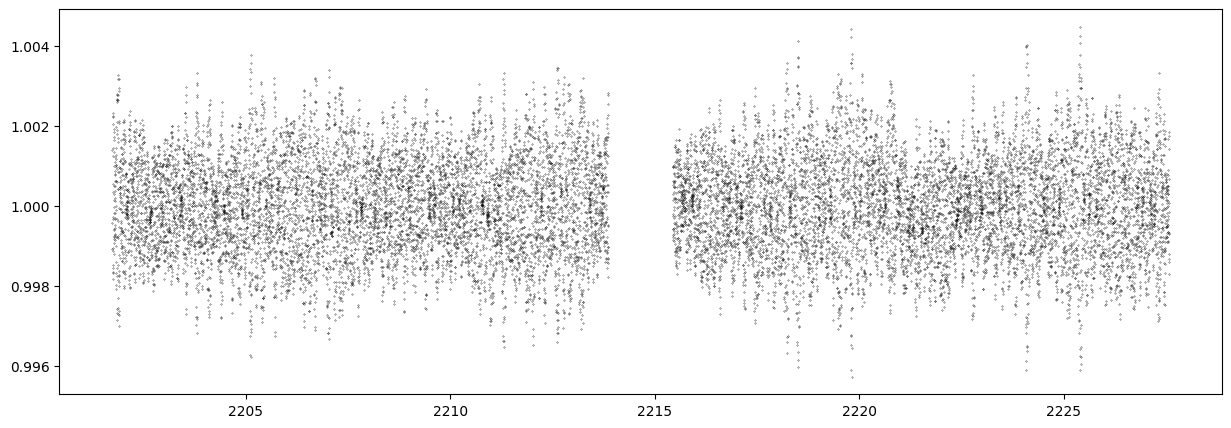

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(time, flux, ".", c="k", ms=0.5)

## GP kernel optimization

In [5]:
from tinygp import GaussianProcess, kernels
import jax.numpy as jnp


def Rotation(sigma, period, Q0, dQ, f):
    Q1 = 1 / 2 + Q0 + dQ
    w1 = (4 * jnp.pi * Q1) / (period * jnp.sqrt(4 * Q1**2 - 1))
    s1 = sigma**2 / ((1 + f) * w1 * Q1)

    Q2 = 1 / 2 + Q0
    w2 = (8 * jnp.pi * Q1) / (period * jnp.sqrt(4 * Q1**2 - 1))
    s2 = f * sigma**2 / ((1 + f) * w2 * Q2)
    kernel = kernels.quasisep.SHO(w1, Q1, s1) + kernels.quasisep.SHO(w2, Q2, s2)
    return kernel


def rotation(period=None, error=None, long_scale=0.2):
    params = {
        "log_period": jnp.log(period) if period is not None else jnp.log(1.0),
        "log_Q": jnp.log(100),
        "log_sigma": jnp.log(1e-1),
        "log_dQ": jnp.log(100),
        "log_f": jnp.log(2.0),
        "log_short_scale": jnp.log(1e-2),
        "log_short_sigma": jnp.log(1e-2),
        "log_long_sigma": jnp.log(1e-2),
        "log_jitter": jnp.log(1.0) if error is None else jnp.log(error),
    }

    def build_gp(params, time, mean=0.0):
        jitter2 = jnp.exp(2 * params["log_jitter"])

        kernel = Rotation(
            jnp.exp(params["log_sigma"]),
            jnp.exp(params["log_period"]),
            jnp.exp(params["log_Q"]),
            jnp.exp(params["log_dQ"]),
            jnp.exp(params["log_f"]),
        )

        return GaussianProcess(kernel, time, diag=jitter2, mean=mean)

    return build_gp, params

In [6]:
import jax

jax.config.update("jax_enable_x64", True)

from nuance import Nuance

# rotation period from literature or Lomb-Scargle
star_period = 0.5

# building a Nuance object
nu = Nuance(time, flux, error.mean())

# building the default rotation GP (provided by Nuance)
build_gp, init = rotation(star_period, error.mean(), long_scale=1)
optimize, mu, nll = nu.gp_optimization(build_gp)

# optimization
gp_params = optimize(init, ["log_sigma", "log_short_sigma", "log_long_sigma"])
gp_params = optimize(gp_params)

gp = build_gp(gp_params, time)
nu = Nuance(time, flux, gp=gp)

/Users/lgarcia/mambaforge/envs/nuance/lib/python3.11/site-packages/nuance/combined.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


ScipyMinimizeInfo(fun_val=Array(-117498.48092716, dtype=float64, weak_type=True), success=True, status=0, iter_num=6)
ScipyMinimizeInfo(fun_val=Array(-128778.69631561, dtype=float64, weak_type=True), success=False, status=2, iter_num=23)


In [7]:
nu_cleaned = nu.copy()

Let's see the cleaned light curve

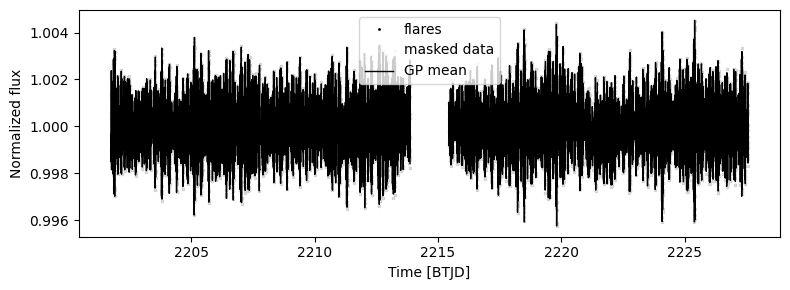

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(nu.time, nu.flux, ".", c="k", ms=2, label="flares")
plt.plot(nu_cleaned.time, nu_cleaned.flux, ".", c="0.85", ms=3, label="masked data")

gp_mean = nu_cleaned.mu(None)
split_idxs = [
    0,
    *np.flatnonzero(np.diff(time) > 10 / 60 / 24),
    len(time),
]

_ = True
for i in range(len(split_idxs) - 1):
    x = nu_cleaned.time[split_idxs[i] + 1 : split_idxs[i + 1]]
    y = gp_mean[split_idxs[i] + 1 : split_idxs[i + 1]]
    plt.plot(x, y, "k", label="GP mean" if _ else None, lw=1)
    _ = False

plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized flux")
plt.legend()
plt.tight_layout()

## Exocomet search

All the above is data preparation, now is time to actually search the cleaned light curve


### The model

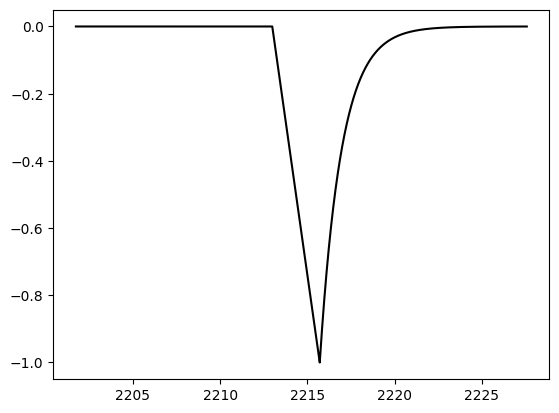

In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


def exocomet(time, t0, duration, P=None, n=3):
    flat = jnp.zeros_like(time)
    left = -(time - (t0 - duration / n)) / (duration / n)
    right = -jnp.exp(-2 / duration * (time - t0 - duration / n)) ** 2
    triangle = jnp.maximum(left, right)
    mask = time >= t0 - duration / n
    signal = jnp.where(mask, triangle, flat)
    return signal / jnp.max(jnp.array([-jnp.min(signal), 1]))


plt.plot(time, exocomet(time, np.mean(time), 5), c="k")

In [10]:
t0s = time.copy()
Ds = np.linspace(1 / 24, 1.5, 20)

gp = build_gp(gp_params, time)
nu = Nuance(time, flux, gp=gp, model=exocomet)
nu.linear_search(t0s, Ds)

  0%|          | 0/1455 [00:00<?, ?it/s]

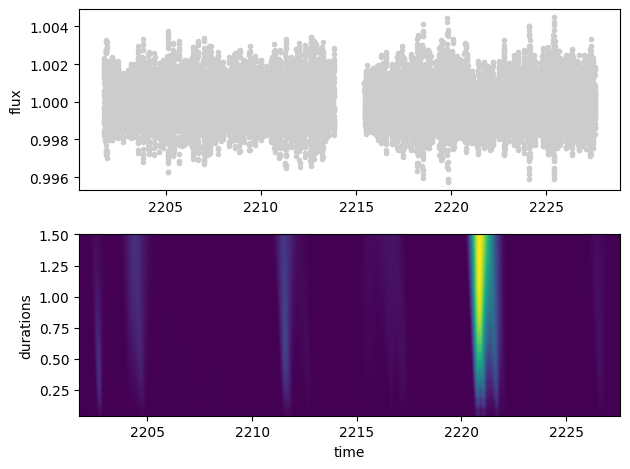

In [11]:
plt.subplot(211)
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")

plt.subplot(212)
nu.search_data.show_ll()
plt.ylabel("durations")
plt.xlabel("time")

plt.tight_layout()

In [12]:
from tqdm import tqdm

snrs = np.array(
    [nu.snr(t0, Ds[np.argmax(nu.search_data.ll[i])]) for i, t0 in enumerate(tqdm(t0s))]
)

100%|██████████| 17458/17458 [00:18<00:00, 962.87it/s] 


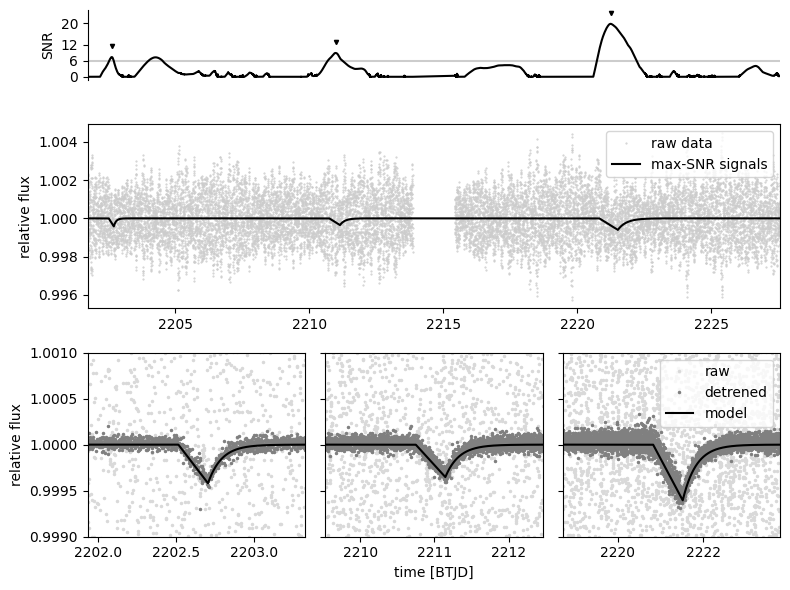

In [13]:
plt.figure(figsize=(8, 6))

xmin, xmax = 1410, 1415

ms = 3

i, j = np.unravel_index(np.argmax(nu.search_data.ll), nu.search_data.ll.shape)
t0, D = nu.search_data.t0s[i], nu.search_data.Ds[j]
linear, astro, noise = nu.models(t0, D)
# plt.figure(figsize=(8, 3))
n = 5
min_snr = 6
ax = plt.subplot(n, 3, (1, 3))
ax.plot(time, snrs, "-", c="k")
ax.axhline(min_snr, c="k", alpha=0.2)
# remove x axis and spine
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, min_snr, 12, 20])
ax.set_xlim(time.min(), time.max())
ax.set_ylabel("SNR")

from scipy.signal import find_peaks

peaks, _ = find_peaks(snrs, height=min_snr, distance=0.5 / np.diff(time).mean())
peaks = peaks[np.argsort(snrs[peaks])[::-1]][0:3]
peaks = peaks[np.argsort(time[peaks])]
ax.plot(time[peaks], snrs[peaks] + 4, "v", c="k", ms=ms)

plt.subplot(n, 3, (4, 9))

signals = []
for peak in peaks:
    t0 = t0s[peak]
    j = np.argmax(nu.search_data.ll[peak])
    D = nu.search_data.Ds[j]
    linear, astro, noise = nu.models(t0, D)
    signals.append(astro)
signals = np.min(signals, axis=0) + 1.0

plt.plot(time, flux, ".", c="0.8", ms=1, label="raw data")
plt.plot(time, signals, "k", label="max-SNR signals")
plt.xlim(time.min(), time.max())
plt.ylabel("relative flux")
plt.legend(loc="upper right")

for i, peak in enumerate(peaks):
    ax = plt.subplot(n, 3, (10 + i, 13 + i))
    t0 = t0s[peak]
    j = np.argmax(nu.search_data.ll[peak])
    D = nu.search_data.Ds[j]
    linear, astro, noise = nu.models(t0, D)
    plt.plot(time, flux, ".", c="0.85", ms=ms, label="raw" if i == 2 else None)
    plt.plot(
        time,
        flux - noise,
        ".",
        c="0.5",
        ms=ms,
        label="detrened" if i == 2 else None,
    )
    plt.plot(time, astro + 1, c="k", label="model" if i == 2 else None)
    xmin, xmax = t0 + 2 * np.array([-1, 1]) * D
    plt.xlim(xmin, xmax)
    plt.ylim(0.999, 1.001)
    plt.plot(nu.search_data.Ds, nu.search_data.ll[peak], c="k")
    if i != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("relative flux")
    if i == 1:
        ax.set_xlabel("time [BTJD]")
    if i == 2:
        ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig("exocomet.pdf")